Created by: Leonardo Porcacchia, leonardo.porcacchia@gmail.com  
This Jupyter Notebook is aimed at extracting meterological data from monthly averaged ERA5 datasets, available at:  
https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=overview  
The data covers two boundig boxes including Brazil, Colombia, Vitenma, and Indonesia, the biggest producers of coffee since 1960.

**Import the library I will use**

In [14]:
import pandas as pd
import numpy as np
import sys
import os
import gc
import glob
import csv
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText

from shapely.geometry import box
from datetime import date, timedelta, datetime

import h5py
import netCDF4 as nc
from netCDF4 import Dataset as netcdf_dataset

from pyproj import Proj, Geod

import rioxarray
import xarray as xr

from tqdm import tqdm

In [18]:
world = gpd.read_file('./Countries/ne_110m_admin_0_countries.shp')

In [20]:
brazil = world[world['ADMIN'] == 'Brazil'].explode(index_parts=True).reset_index(drop=True)

In [22]:
regions = world[world['CONTINENT'].isin(['South America', 'North America', 'Asia'])]

In [24]:
brazil_states = gpd.read_file('./Countries/gadm41_BRA_1.shp')       # GADM level 1 for Brazil
colombia_depts = gpd.read_file('./Countries/gadm41_COL_1.shp')      # GADM level 1 for Colombia

**Brazilian regions producing Arabica**

In [28]:
arabica_states_brazil = [ "Minas Gerais", "São Paulo", "Paraná", "Bahia", "Espírito Santo" ]

**Colombian departments producing Arabica**

In [31]:
arabica_depts_colombia = [ "Caldas", "Risaralda", "Quindío", "Tolima", "Huila", "Antioquia", "Cauca", "Nariño", "Valle del Cauca" ]

In [33]:
# Filter Arabica-producing regions
highlight_brazil = brazil_states[brazil_states['NAME_1'].isin(arabica_states_brazil)]
highlight_colombia = colombia_depts[colombia_depts['NAME_1'].isin(arabica_depts_colombia)]

**Plot the regions/departments where Arabica is produced**

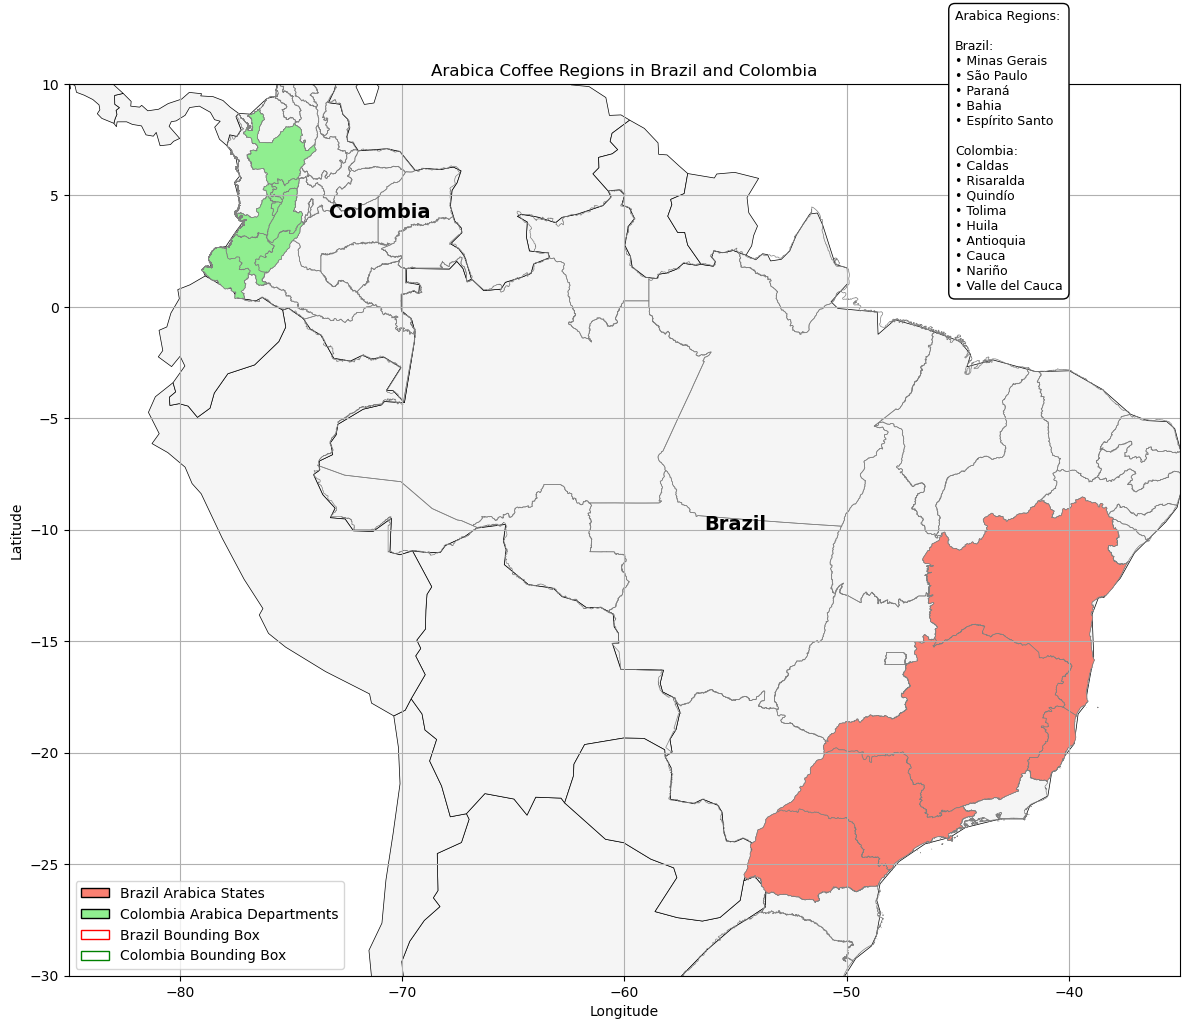

In [38]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot base map (from Natural Earth)
regions.plot(ax=ax, color='whitesmoke', edgecolor='black', linewidth=0.5)

# Plot full borders
brazil_states.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5)
colombia_depts.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5)

# Plot Arabica regions filled with color
highlight_brazil.plot(ax=ax, color='salmon', edgecolor='gray', linewidth=0.5)
highlight_colombia.plot(ax=ax, color='lightgreen', edgecolor='gray', linewidth=0.5)


# Set limits and labels
ax.set_xlim(-85, -35)
ax.set_ylim(-30, 10)
ax.set_title("Arabica Coffee Regions in Brazil and Colombia")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

# Add custom legend for bounding boxes
legend_elements = [
    Patch(facecolor='salmon', edgecolor='black', label='Brazil Arabica States'),
    Patch(facecolor='lightgreen', edgecolor='black', label='Colombia Arabica Departments'),
    Patch(facecolor='none', edgecolor='red', label='Brazil Bounding Box'),
    Patch(facecolor='none', edgecolor='green', label='Colombia Bounding Box')
]
ax.legend(handles=legend_elements, loc='lower left')

# Add regional names in a separate text box (move to top right)
legend_text = (
    "Arabica Regions:\n"
    "\nBrazil:\n" +
    "\n".join(f"• {state}" for state in arabica_states_brazil) +
    "\n\nColombia:\n" +
    "\n".join(f"• {dept}" for dept in arabica_depts_colombia)
)

plt.gcf().text(
    0.80, 0.70,  # x, y in figure coordinates — moved up/right
    legend_text,
    fontsize=9,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)


# Add country name labels
ax.text(-55, -10, "Brazil", fontsize=14, fontweight='bold', ha='center')
ax.text(-71, 4, "Colombia", fontsize=14, fontweight='bold', ha='center')


plt.tight_layout()
plt.show()

**I do the same with Vietnam and Indonesia: isolate the provinces where Robust is produced**

In [45]:
vietnam_admin = gpd.read_file('./Countries/gadm41_VNM_1.shp')       # GADM level 1 for Brazil
indonesia_admin = gpd.read_file('./Countries/gadm41_IDN_1.shp')      # GADM level 1 for Colombia

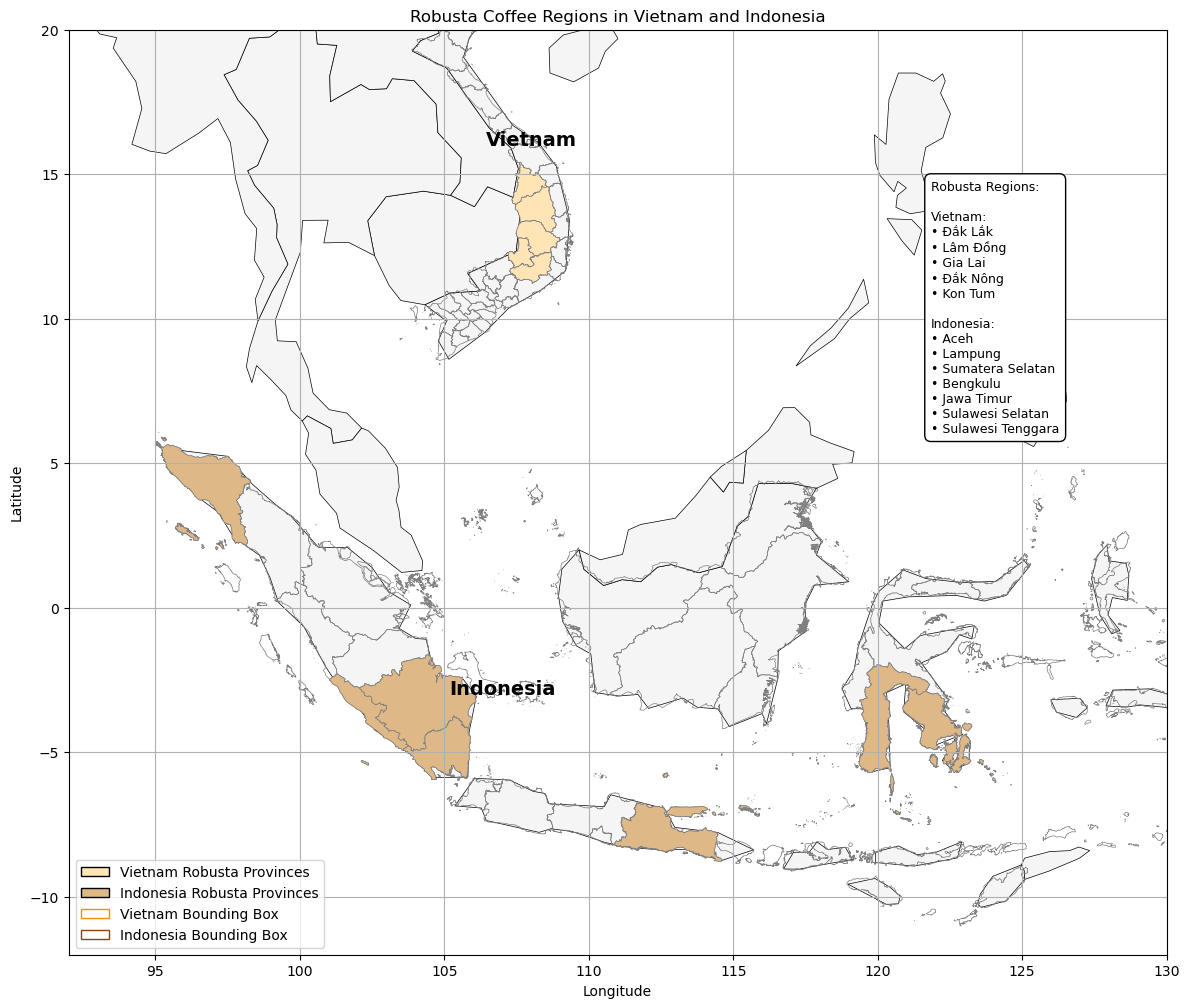

In [47]:
# Define tight bounding boxes
bbox_vietnam = box(107.0, 11.0, 109.0, 15.0)  # Central Highlands
bbox_indonesia = box(101.0, -8.5, 114.5, -2)  # Sumatra, Java, Sulawesi

# Convert to GeoDataFrames
bbox_vietnam_gdf = gpd.GeoDataFrame({'geometry': [bbox_vietnam]}, crs="EPSG:4326")
bbox_indonesia_gdf = gpd.GeoDataFrame({'geometry': [bbox_indonesia]}, crs="EPSG:4326")

# Robusta provinces
robusta_provinces_vietnam = ["Đắk Lắk", "Lâm Đồng", "Gia Lai", "Đắk Nông", "Kon Tum"]
robusta_provinces_indonesia = [ "Aceh", "Lampung", "Sumatera Selatan", "Bengkulu",
    "Jawa Timur", "Sulawesi Selatan", "Sulawesi Tenggara" ]

# Filter Robusta-producing provinces
highlight_vietnam = vietnam_admin[vietnam_admin["NAME_1"].isin(robusta_provinces_vietnam)]
highlight_indonesia = indonesia_admin[indonesia_admin["NAME_1"].isin(robusta_provinces_indonesia)]

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Base map
regions.plot(ax=ax, color='whitesmoke', edgecolor='black', linewidth=0.5)

# Plot all admin borders
vietnam_admin.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5)
indonesia_admin.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5)

# Highlight Robusta regions
highlight_vietnam.plot(ax=ax, color='moccasin', edgecolor='gray', linewidth=0.5)
highlight_indonesia.plot(ax=ax, color='burlywood', edgecolor='gray', linewidth=0.5)

# Country labels
ax.text(108, 16, "Vietnam", fontsize=14, fontweight='bold', ha='center')
ax.text(107, -3, "Indonesia", fontsize=14, fontweight='bold', ha='center')

# Map title and layout
ax.set_xlim(92, 130)
ax.set_ylim(-12, 20)
ax.set_title("Robusta Coffee Regions in Vietnam and Indonesia")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

# Custom legend
legend_elements = [
    Patch(facecolor='moccasin', edgecolor='black', label='Vietnam Robusta Provinces'),
    Patch(facecolor='burlywood', edgecolor='black', label='Indonesia Robusta Provinces'),
    Patch(facecolor='none', edgecolor='darkorange', label='Vietnam Bounding Box'),
    Patch(facecolor='none', edgecolor='saddlebrown', label='Indonesia Bounding Box')
]
ax.legend(handles=legend_elements, loc='lower left')

# Text box with province names
legend_text = (
    "Robusta Regions:\n"
    "\nVietnam:\n" +
    "\n".join(f"• {p}" for p in robusta_provinces_vietnam) +
    "\n\nIndonesia:\n" +
    "\n".join(f"• {p}" for p in robusta_provinces_indonesia)
)

plt.gcf().text(
    0.78, 0.55,
    legend_text,
    fontsize=9,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()
plt.show()

**I already dowloaded the ERA5 datasets and now I extract the variables**

In [51]:
path = "./data_BRA_COL/"

In [53]:
data0 = path + "data_0.nc"
data1 = path + "data_1.nc"
data2 = path + "data_2.nc"

In [55]:
netcdf_dataset(data0).dimensions

{'valid_time': "<class 'netCDF4.Dimension'>": name = 'valid_time', size = 783,
 'latitude': "<class 'netCDF4.Dimension'>": name = 'latitude', size = 161,
 'longitude': "<class 'netCDF4.Dimension'>": name = 'longitude', size = 201}

In [57]:
netcdf_dataset(data1).dimensions

{'valid_time': "<class 'netCDF4.Dimension'>": name = 'valid_time', size = 783,
 'latitude': "<class 'netCDF4.Dimension'>": name = 'latitude', size = 161,
 'longitude': "<class 'netCDF4.Dimension'>": name = 'longitude', size = 201}

In [59]:
netcdf_dataset(data2).dimensions

{'valid_time': "<class 'netCDF4.Dimension'>": name = 'valid_time', size = 783,
 'latitude': "<class 'netCDF4.Dimension'>": name = 'latitude', size = 161,
 'longitude': "<class 'netCDF4.Dimension'>": name = 'longitude', size = 201}

In [61]:
netcdf_dataset(data0).variables.keys()

dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 'swvl1', 'swvl2', 'swvl3', 'stl1'])

In [63]:
netcdf_dataset(data1).variables.keys()

dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 'slt', 'u10', 'v10', 't2m', 'd2m'])

In [65]:
netcdf_dataset(data2).variables.keys()

dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 'ssrd', 'e', 'tp'])

**These are my variables of interest, contained in 3 different files**

In [39]:
#tp = netcdf_dataset(data2).variables['tp'][:]            #total precipitation
#t2m = netcdf_dataset(data1).variables['t2m'][:]          #2m temperature
#u10m = netcdf_dataset(data1).variables['u10'][:]         #10m velocity u component
#v10m = netcdf_dataset(data1).variables['v10'][:]         #10m velocity v component 
#soil = netcdf_dataset(data1).variables['slt'][:]         #soil type
#soil_t = netcdf_dataset(data0).variables['stl1'][:]      #soil temperature level 1
#water1 = netcdf_dataset(data0).variables['swvl1'][:]     #volumetric sil water level 1
#water2 = netcdf_dataset(data0).variables['swvl2'][:]     #volumetric sil water level 2
#water3 = netcdf_dataset(data0).variables['swvl3'][:]     #volumetric sil water level 3
#rad = netcdf_dataset(data2).variables['ssrd'][:]         #surface short_wave radiation downward
#evap = netcdf_dataset(data2).variables['e'][:]           #evaporation

**Time in seconds since 01/01/1970**

In [79]:
time_sec = netcdf_dataset(data2).variables['valid_time'][:]

**Convert time data to datetime format**

In [82]:
time_dt = pd.to_datetime(time_sec, unit='s', origin='unix')

In [84]:
time_dt

DatetimeIndex(['1960-01-01 06:00:00', '1960-02-01 06:00:00',
               '1960-03-01 06:00:00', '1960-04-01 06:00:00',
               '1960-05-01 06:00:00', '1960-06-01 06:00:00',
               '1960-07-01 06:00:00', '1960-08-01 06:00:00',
               '1960-09-01 06:00:00', '1960-10-01 06:00:00',
               ...
               '2024-06-01 06:00:00', '2024-07-01 06:00:00',
               '2024-08-01 06:00:00', '2024-09-01 06:00:00',
               '2024-10-01 06:00:00', '2024-11-01 06:00:00',
               '2024-12-01 06:00:00', '2025-01-01 06:00:00',
               '2025-02-01 06:00:00', '2025-03-01 06:00:00'],
              dtype='datetime64[ns]', length=783, freq=None)

**Extract Longitude and Latitude**

In [87]:
lon = netcdf_dataset(data0).variables['longitude'][:].data
lat = netcdf_dataset(data0).variables['latitude'][:].data
#intervals of 0.25 degrees

**Le'ts take a look at Total Precipitation over Brazil**

In [110]:
ds = xr.open_dataset(path + 'data_2.nc')
ds = ds.rio.write_crs("EPSG:4326")  # Set CRS if missing

In [112]:
#Arabic Brazil
arabica_states_brazil = ["Minas Gerais", "São Paulo", "Paraná", "Bahia", "Espírito Santo"]

In [114]:
gdf = gpd.read_file('./Countries/gadm41_BRA_1.shp')  
arabica_gdf = gdf[gdf["NAME_1"].isin(arabica_states_brazil)]

In [116]:
tp_clipped = ds['tp'].rio.clip(arabica_gdf.geometry, arabica_gdf.crs, drop=True)
tp_clipped = tp_clipped*31 #Total Precipitation per day needs to be multiplied by number of days in month

In [117]:
tp_clipped.shape

(783, 72, 68)

In [119]:
print("Clipped lat range:", float(tp_clipped.latitude.min()), "to", float(tp_clipped.latitude.max()))
print("Clipped lon range:", float(tp_clipped.longitude.min()), "to", float(tp_clipped.longitude.max()))

Clipped lat range: -26.5 to -8.75
Clipped lon range: -54.5 to -37.75


**Plot the average Total Precipitation for the first timestep, January 1960**

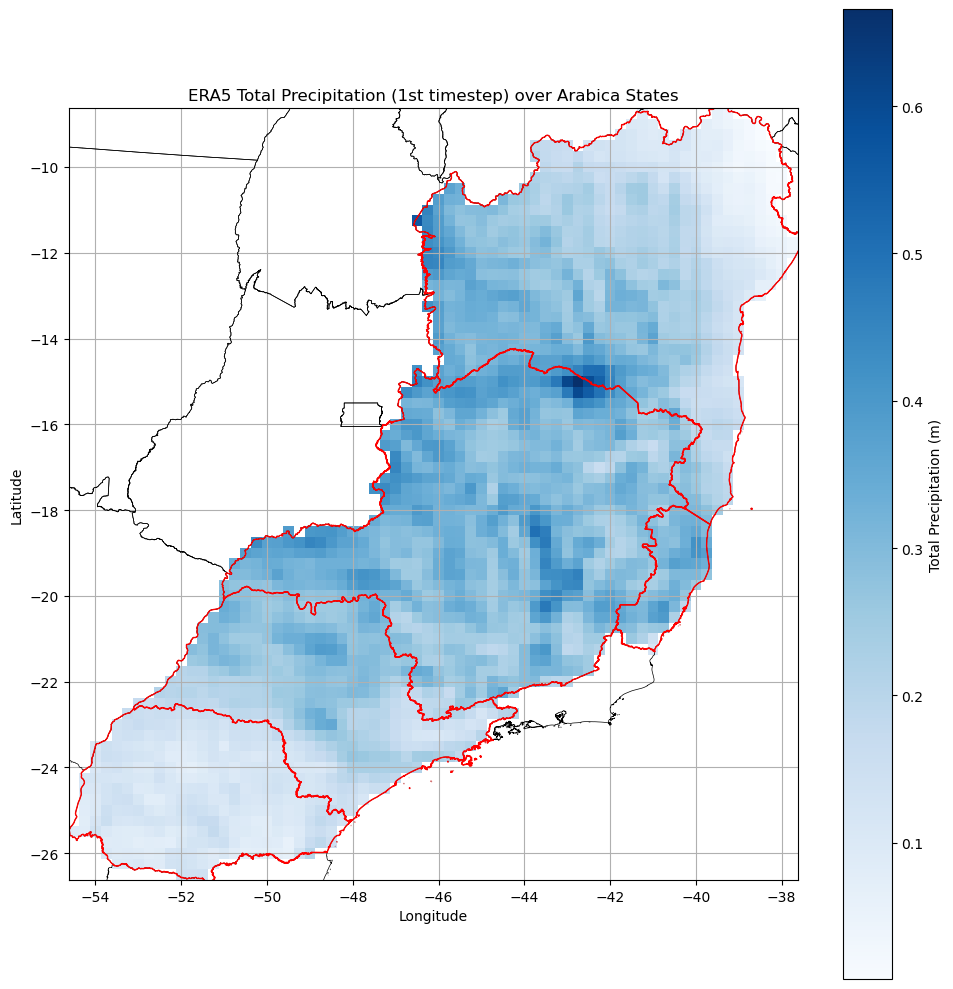

In [125]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Plot setup
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the first time step of total precipitation
tp_clipped.isel(valid_time=0).plot(
    ax=ax,
    cmap='Blues',
    cbar_kwargs={'label': 'Total Precipitation (m)'},
)

# Overlay state borders
brazil_states.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Optional: Highlight Arabica states
arabica_states = ["Minas Gerais", "São Paulo", "Paraná", "Bahia", "Espírito Santo"]
highlight = brazil_states[brazil_states["NAME_1"].isin(arabica_states)]
highlight.boundary.plot(ax=ax, color='red', linewidth=1)

# Final tweaks
ax.set_title("ERA5 Total Precipitation (1st timestep) over Arabica States")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

**Create a dataframe for Brazil including, per each month, all the variables averaged over the coffee producing regions**  
*In Brazil both Arabica and Robusta are produced. I add in the dataframe a column for the type of coffee, which will be useful for the final dataset as well* 

In [96]:
# --- Step 1: Define paths ---
path = "./data_BRA_COL/"

# --- Step 2: Load Brazil shapefile and filter for all coffee states ---
brazil_states = gpd.read_file('./Countries/gadm41_BRA_1.shp')

# Full list of states where coffee is produced
coffee_states_brazil = [
    "Minas Gerais", "São Paulo", "Paraná", "Bahia", "Espírito Santo", "Rondônia"
]

brazil_coffee_gdf = brazil_states[brazil_states["NAME_1"].isin(coffee_states_brazil)]

# --- Step 3: Load climate variable datasets as xarray.DataArray ---
datasets = {
    "tp": xr.open_dataset(path + "data_2.nc")["tp"],
    "ssrd": xr.open_dataset(path + "data_2.nc")["ssrd"],
    "e": xr.open_dataset(path + "data_2.nc")["e"],
    "t2m": xr.open_dataset(path + "data_1.nc")["t2m"],
    "u10": xr.open_dataset(path + "data_1.nc")["u10"],
    "v10": xr.open_dataset(path + "data_1.nc")["v10"],
    "slt": xr.open_dataset(path + "data_1.nc")["slt"],
    "d2m": xr.open_dataset(path + "data_1.nc")["d2m"],
    "stl1": xr.open_dataset(path + "data_0.nc")["stl1"],
    "swvl1": xr.open_dataset(path + "data_0.nc")["swvl1"],
    "swvl2": xr.open_dataset(path + "data_0.nc")["swvl2"],
    "swvl3": xr.open_dataset(path + "data_0.nc")["swvl3"]
}

# --- Step 4: Assign CRS to all datasets ---
for da in datasets.values():
    da.rio.write_crs("EPSG:4326", inplace=True)

# --- Step 5: Loop through regions and extract averages ---
all_results = []

for _, row in tqdm(brazil_coffee_gdf.iterrows(), total=brazil_coffee_gdf.shape[0], desc="Processing states"):
    region_name = row["NAME_1"]
    region_gdf = gpd.GeoDataFrame([row], crs=brazil_coffee_gdf.crs)
    region_df = None

    for var_name, da in tqdm(datasets.items(), desc=f"Processing variables for {region_name}", leave=False):
        try:
            # Clip and average over spatial dimensions
            clipped = da.rio.clip(region_gdf.geometry, region_gdf.crs, drop=True)
            mean_ts = clipped.mean(dim=["latitude", "longitude"], skipna=True).to_dataframe().reset_index()

            # Convert and normalize time
            mean_ts["valid_time"] = pd.to_datetime(mean_ts["valid_time"], unit="s", origin="unix")
            mean_ts["valid_time"] = mean_ts["valid_time"].dt.floor("D") + pd.Timedelta(hours=6)

            # Drop extra 'date' column if already present
            if "date" in mean_ts.columns:
                mean_ts = mean_ts.drop(columns=["date"])

            # Rename to common 'date'
            mean_ts = mean_ts.rename(columns={"valid_time": "date"})

            # Keep only relevant columns
            mean_ts = mean_ts[["date", var_name]]

            # Merge into main DataFrame
            if region_df is None:
                region_df = mean_ts
            else:
                if var_name not in region_df.columns:
                    region_df = pd.merge(region_df, mean_ts, on="date", how="outer")

        except Exception as e:
            print(f"❌ Error processing {var_name} for {region_name}: {e}")

    # Add region info
    region_df.insert(0, "region", region_name)
    all_results.append(region_df)

# --- Step 6: Combine all results into final DataFrame ---
Brazil_df = pd.concat(all_results, ignore_index=True)

# --- Step 7: Add country and coffee_type columns ---

# Always Brazil
Brazil_df["country"] = "Brazil"

# Define Robusta-producing states
robusta_states_brazil = ["Espírito Santo", "Rondônia", "Bahia"]

# Assign coffee type dynamically
Brazil_df["coffee_type"] = Brazil_df["region"].apply(
    lambda x: "Robusta" if x in robusta_states_brazil else "Arabica"
)

# --- Step 8: Final preview ---
print("✅ Final Brazil climate DataFrame preview:")
print(Brazil_df.head())

Processing states: 100%|██████████| 6/6 [00:45<00:00,  7.52s/it]                   

✅ Final Brazil climate DataFrame preview:
  region                date        tp        ssrd         e         t2m  \
0  Bahia 1960-01-01 06:00:00  0.007163  19422326.0 -0.002621  297.890594   
1  Bahia 1960-02-01 06:00:00  0.002589  22011932.0 -0.003277  297.580902   
2  Bahia 1960-03-01 06:00:00  0.011435  15255783.0 -0.003117  295.916229   
3  Bahia 1960-04-01 06:00:00  0.001321  18376366.0 -0.003314  296.219421   
4  Bahia 1960-05-01 06:00:00  0.001126  16317827.0 -0.002256  296.147644   

        u10       v10       slt         d2m        stl1     swvl1     swvl2  \
0 -1.268624 -0.417709  2.785904  291.376404  299.645691  0.295714  0.291187   
1 -1.861997  0.447412  2.785904  291.229584  299.029663  0.285595  0.306048   
2 -0.750681 -0.377039  2.785904  293.094055  297.365234  0.388322  0.379701   
3 -1.962225  1.099024  2.785904  291.641632  297.106659  0.316661  0.334173   
4 -1.938118  1.181605  2.785904  290.363403  297.131531  0.239533  0.262020   

      swvl3 country coffee

**I create a dataframe for Colombia with meteorological variables averaged over Arabica producing departments**

In [98]:
# --- Step 1: Define paths ---
path = "./data_BRA_COL/"

# --- Step 2: Load Colombia shapefile and filter for Arabica departments ---
colombia_depts = gpd.read_file('./Countries/gadm41_COL_1.shp')

# Full list of departments where Arabica is produced
coffee_depts_colombia = [
    "Huila", "Tolima", "Caldas", "Quindío", "Risaralda",
    "Antioquia", "Cauca", "Nariño", "Valle del Cauca"
]

colombia_coffee_gdf = colombia_depts[colombia_depts["NAME_1"].isin(coffee_depts_colombia)]

# --- Step 3: Load climate variable datasets as xarray.DataArray ---
datasets = {
    "tp": xr.open_dataset(path + "data_2.nc")["tp"],
    "ssrd": xr.open_dataset(path + "data_2.nc")["ssrd"],
    "e": xr.open_dataset(path + "data_2.nc")["e"],
    "t2m": xr.open_dataset(path + "data_1.nc")["t2m"],
    "u10": xr.open_dataset(path + "data_1.nc")["u10"],
    "v10": xr.open_dataset(path + "data_1.nc")["v10"],
    "slt": xr.open_dataset(path + "data_1.nc")["slt"],
    "d2m": xr.open_dataset(path + "data_1.nc")["d2m"],
    "stl1": xr.open_dataset(path + "data_0.nc")["stl1"],
    "swvl1": xr.open_dataset(path + "data_0.nc")["swvl1"],
    "swvl2": xr.open_dataset(path + "data_0.nc")["swvl2"],
    "swvl3": xr.open_dataset(path + "data_0.nc")["swvl3"]
}

# --- Step 4: Assign CRS to all datasets ---
for da in datasets.values():
    da.rio.write_crs("EPSG:4326", inplace=True)

# --- Step 5: Loop through departments and extract averages ---
all_results = []

for _, row in tqdm(colombia_coffee_gdf.iterrows(), total=colombia_coffee_gdf.shape[0], desc="Processing departments"):
    region_name = row["NAME_1"]
    region_gdf = gpd.GeoDataFrame([row], crs=colombia_coffee_gdf.crs)
    region_df = None

    for var_name, da in tqdm(datasets.items(), desc=f"Processing variables for {region_name}", leave=False):
        try:
            # Clip and average over spatial dimensions
            clipped = da.rio.clip(region_gdf.geometry, region_gdf.crs, drop=True)
            mean_ts = clipped.mean(dim=["latitude", "longitude"], skipna=True).to_dataframe().reset_index()

            # Convert and normalize time
            mean_ts["valid_time"] = pd.to_datetime(mean_ts["valid_time"], unit="s", origin="unix")
            mean_ts["valid_time"] = mean_ts["valid_time"].dt.floor("D") + pd.Timedelta(hours=6)

            # Drop extra 'date' column if already present
            if "date" in mean_ts.columns:
                mean_ts = mean_ts.drop(columns=["date"])

            # Rename to common 'date'
            mean_ts = mean_ts.rename(columns={"valid_time": "date"})

            # Keep only relevant columns
            mean_ts = mean_ts[["date", var_name]]

            # Merge into main DataFrame
            if region_df is None:
                region_df = mean_ts
            else:
                if var_name not in region_df.columns:
                    region_df = pd.merge(region_df, mean_ts, on="date", how="outer")

        except Exception as e:
            print(f"❌ Error processing {var_name} for {region_name}: {e}")

    # Add region info
    region_df.insert(0, "region", region_name)
    all_results.append(region_df)

# --- Step 6: Combine all results into final DataFrame ---
Colombia_df = pd.concat(all_results, ignore_index=True)

# --- Step 7: Add country and coffee_type columns ---

# Always Colombia
Colombia_df["country"] = "Colombia"

# All these departments produce Arabica ➔ assign Arabica directly
Colombia_df["coffee_type"] = "Arabica"

# --- Step 8: Final preview ---
print("✅ Final Colombia climate DataFrame preview:")
print(Colombia_df.head())

Processing departments: 100%|██████████| 9/9 [01:07<00:00,  7.54s/it]                    

✅ Final Colombia climate DataFrame preview:
      region                date        tp        ssrd         e         t2m  \
0  Antioquia 1960-01-01 06:00:00  0.006470  16460928.0 -0.003192  294.495026   
1  Antioquia 1960-02-01 06:00:00  0.006167  18151390.0 -0.003330  294.929657   
2  Antioquia 1960-03-01 06:00:00  0.009341  18076538.0 -0.003338  294.908630   
3  Antioquia 1960-04-01 06:00:00  0.014092  16411171.0 -0.003309  294.921997   
4  Antioquia 1960-05-01 06:00:00  0.016474  15411520.0 -0.003279  295.043457   

        u10       v10       slt         d2m        stl1     swvl1     swvl2  \
0  0.024971 -0.290435  3.295455  292.041382  294.467468  0.433365  0.431075   
1  0.001466 -0.338696  3.295455  292.059753  294.902374  0.416791  0.411961   
2  0.084464 -0.240524  3.295455  292.187805  295.090057  0.428729  0.418355   
3  0.075300  0.003115  3.295455  292.711884  295.138306  0.454547  0.452593   
4  0.023321  0.217057  3.295455  292.956635  295.146545  0.457373  0.458935   



**Create a Dataframe for Vietnam. Monthly data averaged over Robusta provinces**

In [100]:
# --- Step 1: Define paths ---
path = "./data_VNM_IDN/"

# --- Step 2: Load Vietnam shapefile and filter for Robusta provinces ---
vietnam_provinces = gpd.read_file('./Countries/gadm41_VNM_1.shp')

# Full list of provinces where Robusta is produced (Central Highlands)
robusta_provinces_vietnam = [
    "Đắk Lắk", "Đắk Nông", "Gia Lai", "Lâm Đồng", "Kon Tum"
]

# Handle any possible encoding/simplified names
vietnam_coffee_gdf = vietnam_provinces[vietnam_provinces["NAME_1"].isin(robusta_provinces_vietnam)]

# --- Step 3: Load climate variable datasets as xarray.DataArray ---
datasets = {
    "tp": xr.open_dataset(path + "data_2.nc")["tp"],
    "ssrd": xr.open_dataset(path + "data_2.nc")["ssrd"],
    "e": xr.open_dataset(path + "data_2.nc")["e"],
    "t2m": xr.open_dataset(path + "data_1.nc")["t2m"],
    "u10": xr.open_dataset(path + "data_1.nc")["u10"],
    "v10": xr.open_dataset(path + "data_1.nc")["v10"],
    "slt": xr.open_dataset(path + "data_1.nc")["slt"],
    "d2m": xr.open_dataset(path + "data_1.nc")["d2m"],
    "stl1": xr.open_dataset(path + "data_0.nc")["stl1"],
    "swvl1": xr.open_dataset(path + "data_0.nc")["swvl1"],
    "swvl2": xr.open_dataset(path + "data_0.nc")["swvl2"],
    "swvl3": xr.open_dataset(path + "data_0.nc")["swvl3"]
}

# --- Step 4: Assign CRS to all datasets ---
for da in datasets.values():
    da.rio.write_crs("EPSG:4326", inplace=True)

# --- Step 5: Loop through provinces and extract averages ---
all_results = []

for _, row in tqdm(vietnam_coffee_gdf.iterrows(), total=vietnam_coffee_gdf.shape[0], desc="Processing provinces (Vietnam)"):
    region_name = row["NAME_1"]
    region_gdf = gpd.GeoDataFrame([row], crs=vietnam_coffee_gdf.crs)
    region_df = None

    for var_name, da in tqdm(datasets.items(), desc=f"Processing variables for {region_name}", leave=False):
        try:
            # Clip and average over spatial dimensions
            clipped = da.rio.clip(region_gdf.geometry, region_gdf.crs, drop=True)
            mean_ts = clipped.mean(dim=["latitude", "longitude"], skipna=True).to_dataframe().reset_index()

            # Convert and normalize time
            mean_ts["valid_time"] = pd.to_datetime(mean_ts["valid_time"], unit="s", origin="unix")
            mean_ts["valid_time"] = mean_ts["valid_time"].dt.floor("D") + pd.Timedelta(hours=6)

            if "date" in mean_ts.columns:
                mean_ts = mean_ts.drop(columns=["date"])

            mean_ts = mean_ts.rename(columns={"valid_time": "date"})
            mean_ts = mean_ts[["date", var_name]]

            if region_df is None:
                region_df = mean_ts
            else:
                if var_name not in region_df.columns:
                    region_df = pd.merge(region_df, mean_ts, on="date", how="outer")

        except Exception as e:
            print(f"❌ Error processing {var_name} for {region_name}: {e}")

    region_df.insert(0, "region", region_name)
    all_results.append(region_df)

# --- Step 6: Combine all results into final DataFrame ---
Vietnam_df = pd.concat(all_results, ignore_index=True)

# --- Step 7: Add country and coffee_type columns ---

# Always Vietnam
Vietnam_df["country"] = "Vietnam"

# All selected provinces produce Robusta ➔ assign Robusta directly
Vietnam_df["coffee_type"] = "Robusta"

# --- Step 8: Final preview ---
print("✅ Final Vietnam climate DataFrame preview:")
print(Vietnam_df.head())

Processing provinces (Vietnam): 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]     

✅ Final Vietnam climate DataFrame preview:
    region                date        tp        ssrd         e         t2m  \
0  Đắk Lắk 1960-01-01 06:00:00  0.000654  16084209.0 -0.001859  294.559753   
1  Đắk Lắk 1960-02-01 06:00:00  0.001078  17627136.0 -0.001690  294.815491   
2  Đắk Lắk 1960-03-01 06:00:00  0.000525  23173548.0 -0.002466  298.740631   
3  Đắk Lắk 1960-04-01 06:00:00  0.001721  22889984.0 -0.002898  299.318359   
4  Đắk Lắk 1960-05-01 06:00:00  0.005234  20732656.0 -0.003679  298.988342   

        u10       v10  slt         d2m        stl1     swvl1     swvl2  \
0 -2.963793 -0.924213  4.0  289.797791  295.102936  0.323332  0.349056   
1 -3.323473 -0.990241  4.0  289.458252  295.500092  0.308049  0.322578   
2 -1.241283  0.003083  4.0  291.815826  299.770233  0.283581  0.314600   
3 -1.329902 -0.131009  4.0  293.113464  300.424377  0.321242  0.317091   
4  0.006986  0.317360  4.0  294.787750  300.057281  0.416239  0.387481   

      swvl3  country coffee_type  
0  0.369

**Create a Dataframe for Indonesia. Monthly data averaged over Robusta provinces**

In [102]:
# --- Step 1: Define paths ---
path = "./data_VNM_IDN/"

# --- Step 2: Load Indonesia shapefile and filter for Robusta provinces ---
indonesia_provinces = gpd.read_file('./Countries/gadm41_IDN_1.shp')

# Full list of provinces where Robusta is mainly produced
robusta_provinces_indonesia = [
    "Lampung", "Sumatera Selatan", "Bengkulu", 
    "Jawa Timur", "Jawa Tengah", "Jawa Barat", 
    "Bali", "Kalimantan Barat", "Sulawesi Selatan"
]

indonesia_coffee_gdf = indonesia_provinces[indonesia_provinces["NAME_1"].isin(robusta_provinces_indonesia)]

# --- Step 3: Load climate variable datasets as xarray.DataArray ---
datasets = {
    "tp": xr.open_dataset(path + "data_2.nc")["tp"],
    "ssrd": xr.open_dataset(path + "data_2.nc")["ssrd"],
    "e": xr.open_dataset(path + "data_2.nc")["e"],
    "t2m": xr.open_dataset(path + "data_1.nc")["t2m"],
    "u10": xr.open_dataset(path + "data_1.nc")["u10"],
    "v10": xr.open_dataset(path + "data_1.nc")["v10"],
    "slt": xr.open_dataset(path + "data_1.nc")["slt"],
    "d2m": xr.open_dataset(path + "data_1.nc")["d2m"],
    "stl1": xr.open_dataset(path + "data_0.nc")["stl1"],
    "swvl1": xr.open_dataset(path + "data_0.nc")["swvl1"],
    "swvl2": xr.open_dataset(path + "data_0.nc")["swvl2"],
    "swvl3": xr.open_dataset(path + "data_0.nc")["swvl3"]
}

# --- Step 4: Assign CRS to all datasets ---
for da in datasets.values():
    da.rio.write_crs("EPSG:4326", inplace=True)

# --- Step 5: Loop through provinces and extract averages ---
all_results = []

for _, row in tqdm(indonesia_coffee_gdf.iterrows(), total=indonesia_coffee_gdf.shape[0], desc="Processing provinces (Indonesia)"):
    region_name = row["NAME_1"]
    region_gdf = gpd.GeoDataFrame([row], crs=indonesia_coffee_gdf.crs)
    region_df = None

    for var_name, da in tqdm(datasets.items(), desc=f"Processing variables for {region_name}", leave=False):
        try:
            # Clip and average over spatial dimensions
            clipped = da.rio.clip(region_gdf.geometry, region_gdf.crs, drop=True)
            mean_ts = clipped.mean(dim=["latitude", "longitude"], skipna=True).to_dataframe().reset_index()

            # Convert and normalize time
            mean_ts["valid_time"] = pd.to_datetime(mean_ts["valid_time"], unit="s", origin="unix")
            mean_ts["valid_time"] = mean_ts["valid_time"].dt.floor("D") + pd.Timedelta(hours=6)

            if "date" in mean_ts.columns:
                mean_ts = mean_ts.drop(columns=["date"])

            mean_ts = mean_ts.rename(columns={"valid_time": "date"})
            mean_ts = mean_ts[["date", var_name]]

            if region_df is None:
                region_df = mean_ts
            else:
                if var_name not in region_df.columns:
                    region_df = pd.merge(region_df, mean_ts, on="date", how="outer")

        except Exception as e:
            print(f"❌ Error processing {var_name} for {region_name}: {e}")

    region_df.insert(0, "region", region_name)
    all_results.append(region_df)

# --- Step 6: Combine all results into final DataFrame ---
Indonesia_df = pd.concat(all_results, ignore_index=True)

# --- Step 7: Add country and coffee_type columns ---

# Always Indonesia
Indonesia_df["country"] = "Indonesia"

# All selected provinces produce Robusta ➔ assign Robusta directly
Indonesia_df["coffee_type"] = "Robusta"

# --- Step 8: Final preview ---
print("✅ Final Indonesia climate DataFrame preview:")
print(Indonesia_df.head())

Processing provinces (Indonesia): 100%|██████████| 9/9 [00:43<00:00,  4.88s/it]           

✅ Final Indonesia climate DataFrame preview:
  region                date        tp        ssrd         e         t2m  \
0   Bali 1960-01-01 06:00:00  0.013146  20302166.0 -0.004141  297.710297   
1   Bali 1960-02-01 06:00:00  0.012753  20520732.0 -0.003934  297.519775   
2   Bali 1960-03-01 06:00:00  0.010997  21701622.0 -0.004228  297.744263   
3   Bali 1960-04-01 06:00:00  0.004044  22042852.0 -0.003974  297.924927   
4   Bali 1960-05-01 06:00:00  0.009126  16761230.0 -0.003446  297.664185   

        u10       v10       slt         d2m        stl1     swvl1     swvl2  \
0  0.892037 -0.009997  0.777778  295.359619  299.340515  0.191913  0.193576   
1  1.082279  0.361557  0.777778  295.289398  299.033813  0.190942  0.192902   
2  0.554022  0.688279  0.777778  295.198792  299.471802  0.182861  0.184658   
3 -0.426039  1.030335  0.777778  295.042450  299.275116  0.147813  0.151446   
4 -0.333401  0.436284  0.777778  295.527435  299.163300  0.181575  0.176585   

      swvl3    country 

**Combine all dataframes in a master daframe and I save it to a CSV file** 

In [104]:
coffee_df = pd.concat([Brazil_df, Colombia_df, Vietnam_df, Indonesia_df], ignore_index=True)

In [106]:
coffee_df.head()

,region,date,tp,ssrd,e,t2m,u10,v10,slt,d2m,stl1,swvl1,swvl2,swvl3,country,coffee_type
0,Bahia,1960-01-01 06:00:00,0.007163,19422326.0,-0.002621,297.890594,-1.268624,-0.417709,2.785904,291.376404,299.645691,0.295714,0.291187,0.221570,Brazil,Robusta
1,Bahia,1960-02-01 06:00:00,0.002589,22011932.0,-0.003277,297.580902,-1.861997,0.447412,2.785904,291.229584,299.029663,0.285595,0.306048,0.292125,Brazil,Robusta
2,Bahia,1960-03-01 06:00:00,0.011435,15255783.0,-0.003117,295.916229,-0.750681,-0.377039,2.785904,293.094055,297.365234,0.388322,0.379701,0.347637,Brazil,Robusta
3,Bahia,1960-04-01 06:00:00,0.001321,18376366.0,-0.003314,296.219421,-1.962225,1.099024,2.785904,291.641632,297.106659,0.316661,0.334173,0.353190,Brazil,Robusta
4,Bahia,1960-05-01 06:00:00,0.001126,16317827.0,-0.002256,296.147644,-1.938118,1.181605,2.785904,290.363403,297.131531,0.239533,0.262020,0.300285,Brazil,Robusta


In [110]:
coffee_df.shape

(22707, 16)

In [112]:
# Save to CSV
coffee_df.to_csv("Regions_Climate.csv", index=False)

**This is just to take a look at variables description**

In [114]:
data2 = path + 'data_2.nc'

In [116]:
netcdf_dataset(data2).variables

{'number': <class 'netCDF4.Variable'>
 int64 number()
     long_name: ensemble member numerical id
     units: 1
     standard_name: realization
 unlimited dimensions: 
 current shape = ()
 filling on, default _FillValue of -9223372036854775806 used,
 'valid_time': <class 'netCDF4.Variable'>
 int64 valid_time(valid_time)
     long_name: time
     standard_name: time
     units: seconds since 1970-01-01
     calendar: proleptic_gregorian
 unlimited dimensions: 
 current shape = (783,)
 filling on, default _FillValue of -9223372036854775806 used,
 'latitude': <class 'netCDF4.Variable'>
 float64 latitude(latitude)
     _FillValue: nan
     units: degrees_north
     standard_name: latitude
     long_name: latitude
     stored_direction: decreasing
 unlimited dimensions: 
 current shape = (129,)
 filling on,
 'longitude': <class 'netCDF4.Variable'>
 float64 longitude(longitude)
     _FillValue: nan
     units: degrees_east
     standard_name: longitude
     long_name: longitude
 unlimited d

In [118]:
data1 = path + 'data_1.nc'
netcdf_dataset(data1).variables

{'number': <class 'netCDF4.Variable'>
 int64 number()
     long_name: ensemble member numerical id
     units: 1
     standard_name: realization
 unlimited dimensions: 
 current shape = ()
 filling on, default _FillValue of -9223372036854775806 used,
 'valid_time': <class 'netCDF4.Variable'>
 int64 valid_time(valid_time)
     long_name: time
     standard_name: time
     units: seconds since 1970-01-01
     calendar: proleptic_gregorian
 unlimited dimensions: 
 current shape = (783,)
 filling on, default _FillValue of -9223372036854775806 used,
 'latitude': <class 'netCDF4.Variable'>
 float64 latitude(latitude)
     _FillValue: nan
     units: degrees_north
     standard_name: latitude
     long_name: latitude
     stored_direction: decreasing
 unlimited dimensions: 
 current shape = (129,)
 filling on,
 'longitude': <class 'netCDF4.Variable'>
 float64 longitude(longitude)
     _FillValue: nan
     units: degrees_east
     standard_name: longitude
     long_name: longitude
 unlimited d

In [120]:
data0 = path + 'data_0.nc'
netcdf_dataset(data0).variables

{'number': <class 'netCDF4.Variable'>
 int64 number()
     long_name: ensemble member numerical id
     units: 1
     standard_name: realization
 unlimited dimensions: 
 current shape = ()
 filling on, default _FillValue of -9223372036854775806 used,
 'valid_time': <class 'netCDF4.Variable'>
 int64 valid_time(valid_time)
     long_name: time
     standard_name: time
     units: seconds since 1970-01-01
     calendar: proleptic_gregorian
 unlimited dimensions: 
 current shape = (783,)
 filling on, default _FillValue of -9223372036854775806 used,
 'latitude': <class 'netCDF4.Variable'>
 float64 latitude(latitude)
     _FillValue: nan
     units: degrees_north
     standard_name: latitude
     long_name: latitude
     stored_direction: decreasing
 unlimited dimensions: 
 current shape = (129,)
 filling on,
 'longitude': <class 'netCDF4.Variable'>
 float64 longitude(longitude)
     _FillValue: nan
     units: degrees_east
     standard_name: longitude
     long_name: longitude
 unlimited d

**BONUS**  
**Create dataframes for three more coutntries: Cote D'Ivoire, Uganda, and Angola. They produced most Robusta coffee in the '60s and '70s togheter with Brazil**

Cote d'Ivoire

In [22]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray
from tqdm import tqdm

# --- Step 1: Define paths ---
path = "./data_Africa/"  # (adjust if your folder name is different)

# --- Step 2: Load Côte d'Ivoire shapefile and select full country ---
civ_admin = gpd.read_file('./Countries/gadm41_CIV_1.shp')  # gadm41_CIV_1.shp = Côte d'Ivoire (level 1)

# ➔ In Côte d'Ivoire, almost the whole country produces Robusta.
# So, we take ALL departments.

# You can skip filtering specific regions for now:
civ_coffee_gdf = civ_admin.copy()

# --- Step 3: Load climate variable datasets as xarray.DataArray ---
datasets = {
    "tp": xr.open_dataset(path + "data_2.nc")["tp"],
    "ssrd": xr.open_dataset(path + "data_2.nc")["ssrd"],
    "e": xr.open_dataset(path + "data_2.nc")["e"],
    "t2m": xr.open_dataset(path + "data_1.nc")["t2m"],
    "u10": xr.open_dataset(path + "data_1.nc")["u10"],
    "v10": xr.open_dataset(path + "data_1.nc")["v10"],
    "slt": xr.open_dataset(path + "data_1.nc")["slt"],
    "d2m": xr.open_dataset(path + "data_1.nc")["d2m"],
    "swvl1": xr.open_dataset(path + "data_0.nc")["swvl1"],
    "swvl2": xr.open_dataset(path + "data_0.nc")["swvl2"],
    "swvl3": xr.open_dataset(path + "data_0.nc")["swvl3"]
}

# --- Step 4: Assign CRS to all datasets ---
for da in datasets.values():
    da.rio.write_crs("EPSG:4326", inplace=True)

# --- Step 5: Loop through departments and extract averages ---
all_results = []

for _, row in tqdm(civ_coffee_gdf.iterrows(), total=civ_coffee_gdf.shape[0], desc="Processing departments (Côte d'Ivoire)"):
    region_name = row["NAME_1"]
    region_gdf = gpd.GeoDataFrame([row], crs=civ_coffee_gdf.crs)
    region_df = None

    for var_name, da in tqdm(datasets.items(), desc=f"Processing variables for {region_name}", leave=False):
        try:
            # Clip and average over spatial dimensions
            clipped = da.rio.clip(region_gdf.geometry, region_gdf.crs, drop=True)
            mean_ts = clipped.mean(dim=["latitude", "longitude"], skipna=True).to_dataframe().reset_index()

            # Convert and normalize time
            mean_ts["valid_time"] = pd.to_datetime(mean_ts["valid_time"], unit="s", origin="unix")
            mean_ts["valid_time"] = mean_ts["valid_time"].dt.floor("D") + pd.Timedelta(hours=6)

            if "date" in mean_ts.columns:
                mean_ts = mean_ts.drop(columns=["date"])

            mean_ts = mean_ts.rename(columns={"valid_time": "date"})
            mean_ts = mean_ts[["date", var_name]]

            if region_df is None:
                region_df = mean_ts
            else:
                if var_name not in region_df.columns:
                    region_df = pd.merge(region_df, mean_ts, on="date", how="outer")

        except Exception as e:
            print(f"❌ Error processing {var_name} for {region_name}: {e}")

    region_df.insert(0, "region", region_name)
    all_results.append(region_df)

# --- Step 6: Combine all results into final DataFrame ---
CIV_df = pd.concat(all_results, ignore_index=True)

# --- Step 7: Add country and coffee_type columns ---

# Always Côte d'Ivoire
CIV_df["country"] = "Côte d'Ivoire"

# All departments produce Robusta ➔ assign Robusta
CIV_df["coffee_type"] = "Robusta"

# --- Step 8: Final preview ---
print("✅ Final Côte d'Ivoire climate DataFrame preview:")
print(CIV_df.head())

Processing departments (Côte d'Ivoire): 100%|██████████| 14/14 [00:57<00:00,  4.08s/it]

✅ Final Côte d'Ivoire climate DataFrame preview:
    region                date        tp        ssrd         e         t2m  \
0  Abidjan 1960-01-01 06:00:00  0.003088  18904064.0 -0.003333  298.750000   
1  Abidjan 1960-02-01 06:00:00  0.004626  19616768.0 -0.003706  299.379883   
2  Abidjan 1960-03-01 06:00:00  0.004930  20902616.0 -0.004045  299.240967   
3  Abidjan 1960-04-01 06:00:00  0.005945  20562944.0 -0.004293  299.320557   
4  Abidjan 1960-05-01 06:00:00  0.006383  19292928.0 -0.003988  298.689209   

        u10       v10  slt         d2m     swvl1     swvl2     swvl3  \
0  0.676000  1.303642  2.0  295.947510  0.323269  0.316107  0.337837   
1  0.983239  1.697603  2.0  296.517578  0.356322  0.342309  0.312279   
2  1.261460  1.595641  2.0  296.589600  0.378386  0.370250  0.331613   
3  0.979180  1.466533  2.0  296.911133  0.390558  0.384830  0.346829   
4  0.628568  1.300270  2.0  296.487061  0.402012  0.401723  0.382549   

         country coffee_type  
0  Côte d'Ivoire  

Uganda

In [25]:
# --- Step 2: Load Uganda shapefile and select Robusta-producing districts (lowland areas) ---
uganda_districts = gpd.read_file('./Countries/gadm41_UGA_1.shp')  # gadm41_UGA_1.shp = Uganda Level-1

# List of main Robusta regions (central, south, east Uganda)
robusta_districts_uganda = [
    "Wakiso", "Mpigi", "Masaka", "Jinja", "Kamuli"
]

# Uganda GADM Level-1 has 4 big regions: Central, Eastern, Northern, Western
# (Arabica is mainly in Northern/Eastern mountains: e.g., Mt. Elgon.)

uganda_coffee_gdf = uganda_districts[uganda_districts["NAME_1"].isin(robusta_districts_uganda)]

# --- Step 3: Load climate variable datasets as xarray.DataArray ---
datasets = {
    "tp": xr.open_dataset(path + "data_2.nc")["tp"],
    "ssrd": xr.open_dataset(path + "data_2.nc")["ssrd"],
    "e": xr.open_dataset(path + "data_2.nc")["e"],
    "t2m": xr.open_dataset(path + "data_1.nc")["t2m"],
    "u10": xr.open_dataset(path + "data_1.nc")["u10"],
    "v10": xr.open_dataset(path + "data_1.nc")["v10"],
    "slt": xr.open_dataset(path + "data_1.nc")["slt"],
    "d2m": xr.open_dataset(path + "data_1.nc")["d2m"],
    "swvl1": xr.open_dataset(path + "data_0.nc")["swvl1"],
    "swvl2": xr.open_dataset(path + "data_0.nc")["swvl2"],
    "swvl3": xr.open_dataset(path + "data_0.nc")["swvl3"]
}

# --- Step 4: Assign CRS to all datasets ---
for da in datasets.values():
    da.rio.write_crs("EPSG:4326", inplace=True)

# --- Step 5: Loop through regions and extract averages ---
all_results = []

for _, row in tqdm(uganda_coffee_gdf.iterrows(), total=uganda_coffee_gdf.shape[0], desc="Processing regions (Uganda)"):
    region_name = row["NAME_1"]
    region_gdf = gpd.GeoDataFrame([row], crs=uganda_coffee_gdf.crs)
    region_df = None

    for var_name, da in tqdm(datasets.items(), desc=f"Processing variables for {region_name}", leave=False):
        try:
            clipped = da.rio.clip(region_gdf.geometry, region_gdf.crs, drop=True)
            
            if clipped.size == 0:
                print(f"⚠️ No data for {region_name} on {var_name}. Skipping.")
                continue
            
            mean_ts = clipped.mean(dim=["latitude", "longitude"], skipna=True).to_dataframe().reset_index()
            
            mean_ts["valid_time"] = pd.to_datetime(mean_ts["valid_time"], unit="s", origin="unix")
            mean_ts["valid_time"] = mean_ts["valid_time"].dt.floor("D") + pd.Timedelta(hours=6)
            
            if "date" in mean_ts.columns:
                mean_ts = mean_ts.drop(columns=["date"])
            
            mean_ts = mean_ts.rename(columns={"valid_time": "date"})
            mean_ts = mean_ts[["date", var_name]]
        
            if region_df is None:
                region_df = mean_ts
            else:
                if var_name not in region_df.columns:
                    region_df = pd.merge(region_df, mean_ts, on="date", how="outer")
        
        except Exception as e:
            print(f"❌ Error processing {var_name} for {region_name}: {e}")

    region_df.insert(0, "region", region_name)
    all_results.append(region_df)

# --- Step 6: Combine all results into final DataFrame ---
Uganda_df = pd.concat(all_results, ignore_index=True)

# --- Step 7: Add country and coffee_type columns ---

# Always Uganda
Uganda_df["country"] = "Uganda"

# These regions produce mainly Robusta ➔ assign Robusta
Uganda_df["coffee_type"] = "Robusta"

# --- Step 8: Final preview ---
print("✅ Final Uganda climate DataFrame preview:")
print(Uganda_df.head())

Processing regions (Uganda): 100%|██████████| 5/5 [00:19<00:00,  4.00s/it]      

✅ Final Uganda climate DataFrame preview:
  region                date        tp        ssrd         e         t2m  \
0  Jinja 1960-01-01 06:00:00  0.005962  19641344.0 -0.004174  295.255859   
1  Jinja 1960-02-01 06:00:00  0.008763  20064768.0 -0.004295  295.099609   
2  Jinja 1960-03-01 06:00:00  0.009998  18827992.0 -0.004119  294.754639   
3  Jinja 1960-04-01 06:00:00  0.010868  17426944.0 -0.003763  294.986572   
4  Jinja 1960-05-01 06:00:00  0.008200  17346048.0 -0.003730  294.799561   

        u10       v10  slt         d2m     swvl1     swvl2     swvl3 country  \
0  0.127660  0.686943  4.0  292.470947  0.468380  0.472403  0.471939  Uganda   
1  0.329675  1.011080  4.0  292.227539  0.471663  0.474389  0.474075  Uganda   
2  0.123033  0.779967  4.0  292.120850  0.472990  0.475665  0.474512  Uganda   
3  0.212579  0.891337  4.0  292.674805  0.478082  0.482433  0.484066  Uganda   
4  0.022611  0.293434  4.0  292.428467  0.476841  0.480336  0.473209  Uganda   

  coffee_type  
0   

Angola

In [8]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray
from tqdm import tqdm


path = "./data_Africa/"

# --- Step 2: Load Angola shapefile and select Robusta-producing provinces ---
angola_provinces = gpd.read_file('./Countries/gadm41_AGO_1.shp')  # gadm41_AGO_1.shp = Angola Level-1

# List of Robusta provinces
robusta_provinces_angola = [
    "Uíge", "Cuanza Norte", "Malanje", "Bengo", "Cuanza Sul"
]

# Filter provinces
angola_coffee_gdf = angola_provinces[angola_provinces["NAME_1"].isin(robusta_provinces_angola)]

# --- Step 3: Load climate variable datasets as xarray.DataArray ---
datasets = {
    "tp": xr.open_dataset(path + "data_2.nc")["tp"],
    "ssrd": xr.open_dataset(path + "data_2.nc")["ssrd"],
    "e": xr.open_dataset(path + "data_2.nc")["e"],
    "t2m": xr.open_dataset(path + "data_1.nc")["t2m"],
    "u10": xr.open_dataset(path + "data_1.nc")["u10"],
    "v10": xr.open_dataset(path + "data_1.nc")["v10"],
    "slt": xr.open_dataset(path + "data_1.nc")["slt"],
    "d2m": xr.open_dataset(path + "data_1.nc")["d2m"],
    "swvl1": xr.open_dataset(path + "data_0.nc")["swvl1"],
    "swvl2": xr.open_dataset(path + "data_0.nc")["swvl2"],
    "swvl3": xr.open_dataset(path + "data_0.nc")["swvl3"]
}

# --- Step 4: Assign CRS to all datasets ---
for da in datasets.values():
    da.rio.write_crs("EPSG:4326", inplace=True)

# --- Step 5: Loop through provinces and extract averages ---
all_results = []

for _, row in tqdm(angola_coffee_gdf.iterrows(), total=angola_coffee_gdf.shape[0], desc="Processing provinces (Angola)"):
    region_name = row["NAME_1"]
    region_gdf = gpd.GeoDataFrame([row], crs=angola_coffee_gdf.crs)
    region_df = None

    for var_name, da in tqdm(datasets.items(), desc=f"Processing variables for {region_name}", leave=False):
        try:
            # Clip and check if any data exists
            clipped = da.rio.clip(region_gdf.geometry, region_gdf.crs, drop=True)
            
            if clipped.size == 0:
                print(f"⚠️ No ERA5 data found for {region_name} on {var_name}. Skipping.")
                continue

            mean_ts = clipped.mean(dim=["latitude", "longitude"], skipna=True).to_dataframe().reset_index()
            mean_ts["valid_time"] = pd.to_datetime(mean_ts["valid_time"], unit="s", origin="unix")
            mean_ts["valid_time"] = mean_ts["valid_time"].dt.floor("D") + pd.Timedelta(hours=6)

            if "date" in mean_ts.columns:
                mean_ts = mean_ts.drop(columns=["date"])

            mean_ts = mean_ts.rename(columns={"valid_time": "date"})
            mean_ts = mean_ts[["date", var_name]]

            if region_df is None:
                region_df = mean_ts
            else:
                if var_name not in region_df.columns:
                    region_df = pd.merge(region_df, mean_ts, on="date", how="outer")

        except Exception as e:
            print(f"❌ Error processing {var_name} for {region_name}: {e}")

    if region_df is not None:
        region_df.insert(0, "region", region_name)
        all_results.append(region_df)

# --- Step 6: Combine all results into final DataFrame ---
Angola_df = pd.concat(all_results, ignore_index=True)

# --- Step 7: Add country and coffee_type columns ---

# Always Angola
Angola_df["country"] = "Angola"

# These provinces produce Robusta ➔ assign Robusta
Angola_df["coffee_type"] = "Robusta"

# --- Step 8: Final preview ---
print("✅ Final Angola climate DataFrame preview:")
print(Angola_df.head())

Processing provinces (Angola): 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]  

✅ Final Angola climate DataFrame preview:
  region                date        tp        ssrd         e         t2m  \
0  Bengo 1960-01-01 06:00:00  0.004133  17228490.0 -0.003298  297.926605   
1  Bengo 1960-02-01 06:00:00  0.004081  17904520.0 -0.003605  298.160126   
2  Bengo 1960-03-01 06:00:00  0.006142  18253788.0 -0.003942  298.201355   
3  Bengo 1960-04-01 06:00:00  0.009044  14779928.0 -0.003338  298.144043   
4  Bengo 1960-05-01 06:00:00  0.001878  14249484.0 -0.002894  296.974640   

        u10       v10       slt         d2m     swvl1     swvl2     swvl3  \
0  0.855789  0.271427  2.627907  294.803955  0.317675  0.317372  0.315367   
1  0.927751  0.388703  2.627907  295.080780  0.331970  0.347675  0.329741   
2  0.525149  0.296637  2.627907  295.596436  0.377745  0.378342  0.356949   
3  0.321579  0.813553  2.627907  296.169525  0.407258  0.408890  0.393209   
4  0.565909  1.222350  2.627907  294.656647  0.334241  0.364190  0.390040   

  country coffee_type  
0  Angola     

**Open the previus dataframe saved in CSV file and concatenate the new dataframes**

In [16]:
df = pd.read_csv("Regions_Climate.csv")
df.head()

,region,date,tp,ssrd,e,t2m,u10,v10,slt,d2m,swvl1,swvl2,swvl3,country,coffee_type
0,Bahia,1960-01-01 06:00:00,0.007163,19422326.0,-0.002621,297.89060,-1.268624,-0.417710,2.785904,291.37640,0.295714,0.291187,0.221570,Brazil,Robusta
1,Bahia,1960-02-01 06:00:00,0.002589,22011932.0,-0.003277,297.58090,-1.861997,0.447412,2.785904,291.22958,0.285595,0.306048,0.292125,Brazil,Robusta
2,Bahia,1960-03-01 06:00:00,0.011435,15255783.0,-0.003117,295.91623,-0.750680,-0.377038,2.785904,293.09406,0.388322,0.379701,0.347637,Brazil,Robusta
3,Bahia,1960-04-01 06:00:00,0.001321,18376366.0,-0.003314,296.21942,-1.962225,1.099024,2.785904,291.64163,0.316661,0.334173,0.353190,Brazil,Robusta
4,Bahia,1960-05-01 06:00:00,0.001126,16317827.0,-0.002256,296.14764,-1.938119,1.181605,2.785904,290.36340,0.239533,0.262020,0.300285,Brazil,Robusta


In [27]:
final_df = pd.concat([df, CIV_df, Uganda_df, Angola_df], ignore_index=True)

print(final_df.head())
print(f"Final shape: {final_df.shape}")

  region                 date        tp        ssrd         e        t2m  \
0  Bahia  1960-01-01 06:00:00  0.007163  19422326.0 -0.002621  297.89060   
1  Bahia  1960-02-01 06:00:00  0.002589  22011932.0 -0.003277  297.58090   
2  Bahia  1960-03-01 06:00:00  0.011435  15255783.0 -0.003117  295.91623   
3  Bahia  1960-04-01 06:00:00  0.001321  18376366.0 -0.003314  296.21942   
4  Bahia  1960-05-01 06:00:00  0.001126  16317827.0 -0.002256  296.14764   

        u10       v10       slt        d2m     swvl1     swvl2     swvl3  \
0 -1.268624 -0.417710  2.785904  291.37640  0.295714  0.291187  0.221570   
1 -1.861997  0.447412  2.785904  291.22958  0.285595  0.306048  0.292125   
2 -0.750680 -0.377038  2.785904  293.09406  0.388322  0.379701  0.347637   
3 -1.962225  1.099024  2.785904  291.64163  0.316661  0.334173  0.353190   
4 -1.938119  1.181605  2.785904  290.36340  0.239533  0.262020  0.300285   

  country coffee_type  
0  Brazil     Robusta  
1  Brazil     Robusta  
2  Brazil     

In [29]:
final_df.country.unique()

array(['Brazil', 'Colombia', 'Vietnam', 'Indonesia', "Côte d'Ivoire",
       'Uganda', 'Angola'], dtype=object)

**Finally, save the new dataframe**

In [33]:
final_df.to_csv("Regions_Climate_full.csv", index=False)